# Import

In [1]:
import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import os
import numpy as np
import string
from scipy import linalg
import pandas
import time
import yaml

In [3]:
from pyiron_atomistics import Project
from pyiron_dft_uncertainty import (
    update_uncertainty_parameter,
    get_alat_range,
    calc_set_of_jobs,
    setup_pyiron_table,
    get_potential_encut,
    get_column_from_df,
    calc_v0_from_fit_funct,
    bulk_modulus_from_fit_and_volume,
    bulk_modulus_dereivative_from_fit_and_volume,
    wait_for_jobs_to_be_done,
    double_smooth,
    shift_lst,
    read_from_df,
)

In [4]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

## User Parameters 

In [5]:
with open("input.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.Loader)

In [6]:
uncertainty_parameter = {
    'element': config["element_settings"]['element'],
    'pseudo_potential': config["element_settings"]['pseudo_potential'],
    'crystal_structure': config["element_settings"]['crystal_structure'],
    'alat_guess': config["element_settings"]['alat_guess'],
    'encut_start': config["convergence_settings"]['encut_start'],
    'encut_step': config["convergence_settings"]['encut_step'],
    'encut_end': config["convergence_settings"]['encut_end'],
    'kpoint_start': config["convergence_settings"]['kpoint_start'],
    'kpoint_step': config["convergence_settings"]['kpoint_step'],
    'kpoint_end': config["convergence_settings"]['kpoint_end'],
    'points': config["evcurve_settings"]['points'],
    'vol_range': config["evcurve_settings"]['vol_range'],
    'points_pre': config["evcurve_settings"]['points_pre'],
    'vol_range_pre': config["evcurve_settings"]['vol_range_pre'],
    'queue': config["server_settings"]['queue'],
    'cores': config["server_settings"]['cores'], 
    'run_time': config["server_settings"]['run_time'], 
    'memory_factor': config["server_settings"]['memory_factor'],
    'project_name': config["server_settings"]['project_name'],
}

In [7]:
sleep_period=30
iteration=10000

## Fill up empty parameters

In [8]:
uncertainty_parameter = update_uncertainty_parameter(
    uncertainty_parameter=uncertainty_parameter
)

# Data generation

In [9]:
os.makedirs(name="pyiron/data/" + uncertainty_parameter["element"], exist_ok=True)

In [10]:
encut_space = np.arange(
    uncertainty_parameter['encut_start'], 
    uncertainty_parameter['encut_end'] + uncertainty_parameter['encut_step'], 
    uncertainty_parameter['encut_step']
)

In [11]:
kpoint_space = np.arange(
    uncertainty_parameter['kpoint_start'], 
    uncertainty_parameter['kpoint_end'] + uncertainty_parameter['kpoint_step'], 
    uncertainty_parameter['kpoint_step']
)

In [12]:
cores = uncertainty_parameter['cores'] # compute cores  
memory_factor = uncertainty_parameter['memory_factor'] # x-times 3GB memory 
queue = uncertainty_parameter['queue']

## Initial guess

In [13]:
pr_pre = Project(uncertainty_parameter['project_name'] + "_pre") 

In [14]:
structure_base = pr_pre.create.structure.ase.bulk(uncertainty_parameter["element"])

In [15]:
alat_ten_space = get_alat_range(
    vol_eq=structure_base.get_volume(), 
    strain=uncertainty_parameter['vol_range_pre'], 
    steps=uncertainty_parameter['points_pre'], 
    crystal_structure=uncertainty_parameter['crystal_structure'], 
    number_of_atoms=len(structure_base)
) 

In [16]:
parameter_lst = []
for alat in alat_ten_space:
    parameter_lst.append([alat, encut_space[-1], kpoint_space[-1]])

In [17]:
df_file_name_pre = "pyiron/data/" + uncertainty_parameter["element"] + "/" + uncertainty_parameter['project_name'].lower() + "_pre.csv"
if not os.path.exists(df_file_name_pre):
    calc_set_of_jobs(
        pr=pr_pre, 
        parameter_lst=parameter_lst, 
        uncertainty_parameter=uncertainty_parameter, 
        vasp_parameter=config["vasp_settings"],
        sleep_period=sleep_period, 
        iteration=iteration
    )
    wait_for_jobs_to_be_done(
        project=pr_pre, 
        sleep_period=sleep_period, 
        iteration=iteration
    )
    pytab = setup_pyiron_table(project=pr_pre)
    df_tmp = pytab.get_dataframe()
    df_tmp.to_csv(df_file_name_pre)
calc_df_pre = pandas.read_csv(df_file_name_pre, index_col=0)

In [18]:
vol_range = [
    pr_pre.create.structure.ase.bulk(uncertainty_parameter["element"], a=alat).get_volume() 
    for alat in alat_ten_space
]

In [19]:
vol_lst, eng_lst, el_conv_lst = read_from_df(df=calc_df_pre, encut=encut_space[-1], kpoint=kpoint_space[-1], vol_space=vol_range)

In [20]:
degree_pre = 11

In [21]:
vol_pre_lst, eng_pre_lst = zip(*[[vol, eng] for vol, eng in zip(vol_lst, eng_lst) if eng is not None])


In [22]:
fit_pre = np.poly1d(np.polyfit(vol_pre_lst, eng_pre_lst, degree_pre))


In [23]:
vol_range_pre_big = np.linspace(
    np.min(vol_range),
    np.max(vol_range),
    int(uncertainty_parameter['points_pre']) * 10
)

Text(0, 0.5, 'Energy')

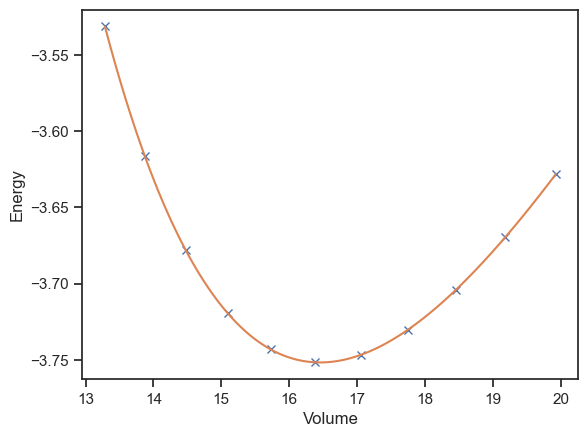

In [24]:
plt.plot(vol_pre_lst, eng_pre_lst, "x")
plt.plot(vol_range_pre_big, fit_pre(vol_range_pre_big))
plt.xlabel("Volume")
plt.ylabel("Energy")

In [25]:
vol_eq = np.round(calc_v0_from_fit_funct(fit_funct=fit_pre, x=vol_pre_lst), 4)
vol_eq

16.4568

## Iterate over parameter space

In [26]:
pr = Project(uncertainty_parameter['project_name']) 

In [27]:
alat_space = get_alat_range(
    vol_eq=vol_eq, 
    strain=uncertainty_parameter['vol_range'], 
    steps=uncertainty_parameter['points'], 
    crystal_structure=uncertainty_parameter['crystal_structure'], 
    number_of_atoms=len(structure_base)
) 

In [28]:
parameter_lst = []
for kpoints in kpoint_space:
    for encut in encut_space:
        for alat in alat_space:
            parameter_lst.append([alat, encut, kpoints])

In [29]:
df_file_name = "pyiron/data/" + uncertainty_parameter["element"] + "/" + uncertainty_parameter['project_name'].lower() + ".csv"
if not os.path.exists(df_file_name):
    calc_set_of_jobs(
        pr=pr, 
        parameter_lst=parameter_lst, 
        uncertainty_parameter=uncertainty_parameter,
        vasp_parameter=config["vasp_settings"],
        sleep_period=sleep_period, 
        iteration=iteration
    )
    wait_for_jobs_to_be_done(
        project=pr, 
        sleep_period=sleep_period, 
        iteration=iteration
    )
    pytab = setup_pyiron_table(project=pr)
    df_tmp = pytab.get_dataframe()
    df_tmp.to_csv(df_file_name)
calc_df = pandas.read_csv(df_file_name, index_col=0)

# Collect calculation

In [30]:
encut_recommended = get_potential_encut(
    el=uncertainty_parameter['pseudo_potential'].split("_")[0], 
    default_potential=uncertainty_parameter['pseudo_potential']
)
ind_select = encut_recommended < encut_space
encut_min = np.min(np.arange(len(encut_space))[ind_select])
encut_space[encut_min], encut_recommended

(260, 240.3)

In [31]:
vol_space = [
    pr.create.structure.ase.bulk(uncertainty_parameter["element"], a=alat).get_volume() 
    for alat in alat_space
]

In [32]:
eng_store_lst = []
for encut in encut_space:
    for kpoint in kpoint_space:
        vol_lst, eng_lst, conv_lst, n_kpts_lst, avg_plane_waves_lst = zip(*[
            [
                get_column_from_df(df=calc_df, column='volume', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6), 
                get_column_from_df(df=calc_df, column='energy_tot', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='el_conv', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='n_equ_kpts', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='avg. plane waves', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6)
            ] for vol_name in vol_space])
        vol_lst, eng_lst, conv_lst, n_kpts_lst, avg_plane_waves_lst = np.array(vol_lst), np.array(eng_lst), np.array(conv_lst), np.array(n_kpts_lst), np.array(avg_plane_waves_lst)
        eng_store_lst.append(eng_lst)

In [33]:
eng_store_mat = np.array(eng_store_lst, dtype=float).reshape(
    len(encut_space), 
    len(kpoint_space), 
    len(vol_space)
)

In [34]:
eng_store_mat.shape

(51, 41, 21)

# Systematic Error

In [35]:
kpoint_min = 2

In [36]:
cmap = cm.get_cmap('Spectral').reversed()

/tmp/ipykernel_9961/2562663318.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral').reversed()


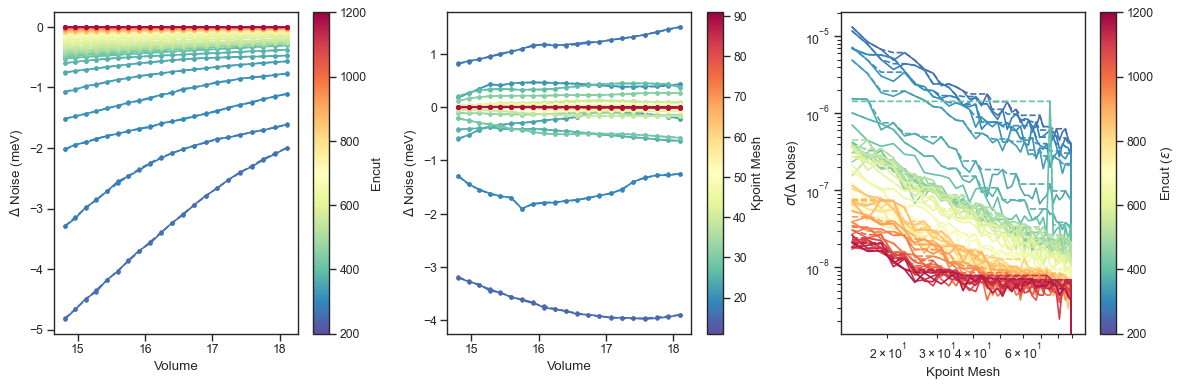

In [37]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
vlen = len(encut_space)
for i, encut in enumerate(encut_space[encut_min:]):
    ediff_low = np.array(eng_store_mat[-1][kpoint_min]) - np.array(eng_store_mat[encut_min+i][kpoint_min])
    ediff_high = np.array(eng_store_mat[-1][-1]) - np.array(eng_store_mat[encut_min+i][-1])
    axs[0].plot(vol_space, ediff_low * 1000, ".-", color=cmap((i+encut_min)/vlen))
    axs[0].plot(vol_space, ediff_high * 1000, ".--", color=cmap((i+encut_min)/vlen))
vlen = len(kpoint_space)
for j, kpoint in enumerate(kpoint_space[kpoint_min:]):
    ediff_low = np.array(eng_store_mat[encut_min][-1]) - np.array(eng_store_mat[encut_min][kpoint_min+j])
    ediff_high = np.array(eng_store_mat[-1][-1]) - np.array(eng_store_mat[-1][kpoint_min+j])
    axs[1].plot(vol_space, ediff_low * 1000, ".-",color=cmap((j+kpoint_min)/vlen))
    axs[1].plot(vol_space, ediff_high * 1000, ".--", color=cmap((j+kpoint_min)/vlen))
axs[0].set_xlabel("Volume")
axs[0].set_ylabel("$\Delta$ Noise (meV)")
axs[1].set_xlabel("Volume")
axs[1].set_ylabel("$\Delta$ Noise (meV)")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[0])
cbar.set_label("Encut")
normalize = mcolors.Normalize(vmin=kpoint_space.min(), vmax=kpoint_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(kpoint_space)
cbar = f.colorbar(scalarmappaple, ax=axs[1])
cbar.set_label("Kpoint Mesh")

vlen = len(encut_space)
for i, encut in enumerate(encut_space[encut_min:]):
    std_lst = []
    for j, kpoint in enumerate(kpoint_space[kpoint_min:]):
        ediff = np.array(eng_store_mat)[i+encut_min][-1]-np.array(eng_store_mat)[i+encut_min][j+kpoint_min]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[-1][j+kpoint_min])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[2].plot(kpoint_space[kpoint_min:], std_lst, color=cmap((i+encut_min)/vlen))
    axs[2].plot(kpoint_space[kpoint_min:], shift_lst(std_lst), "--", color=cmap((i+encut_min)/vlen))
axs[2].set_xlabel("Kpoint Mesh")
axs[2].set_ylabel("$\sigma(\Delta$ Noise)")
axs[2].set_yscale("log")
axs[2].set_xscale("log")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[2])
cbar.set_label("Encut ($\epsilon$)")

plt.tight_layout()
plt.show()

# Statistical Error 

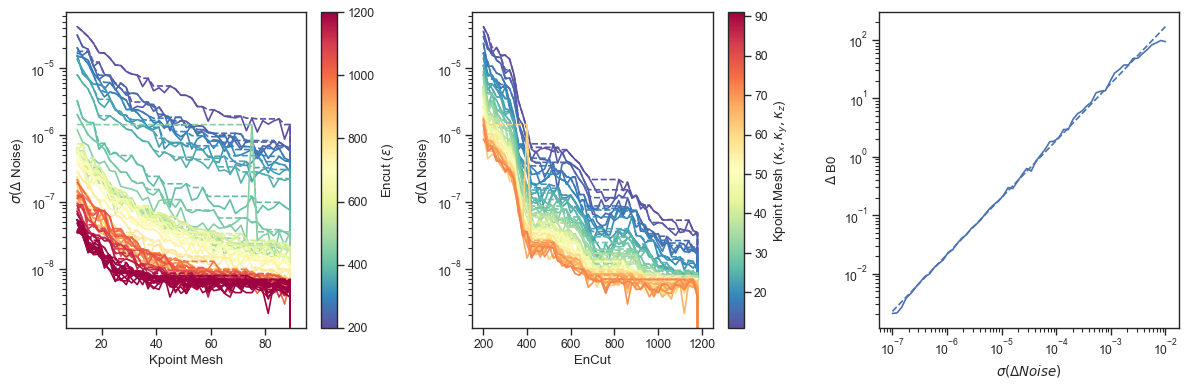

In [38]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)

vlen = len(kpoint_space)
for i, encut in enumerate(encut_space):
    std_lst = []
    for j, kpoint in enumerate(kpoint_space):
        ediff = np.array(eng_store_mat)[i][-1]-np.array(eng_store_mat)[i][j]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[-1][j])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[0].plot(kpoint_space, std_lst, color=cmap(i/vlen))
    axs[0].plot(kpoint_space, shift_lst(std_lst), "--", color=cmap(i/vlen))
axs[0].set_xlabel("Kpoint Mesh")
axs[0].set_ylabel("$\sigma(\Delta$ Noise)")
axs[0].set_yscale("log")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[0])
cbar.set_label("Encut ($\epsilon$)")

vlen = len(encut_space)
for j, kpoint in enumerate(kpoint_space):
    std_lst = []
    for i, encut in enumerate(encut_space):
        ediff = np.array(eng_store_mat)[-1][j]-np.array(eng_store_mat)[i][j]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[i][-1])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[1].plot(encut_space, std_lst, color=cmap(j/vlen))
    axs[1].plot(encut_space, shift_lst(std_lst), "--", color=cmap(j/vlen))
axs[1].set_xlabel("EnCut")
axs[1].set_ylabel("$\sigma(\Delta$ Noise)")
axs[1].set_yscale("log")
normalize = mcolors.Normalize(vmin=kpoint_space.min(), vmax=kpoint_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(kpoint_space)
cbar = f.colorbar(scalarmappaple, ax=axs[1])
cbar.set_label("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")

degree = 13
fit_base = np.poly1d(np.polyfit(vol_space, eng_store_mat[-1][-1], degree))
geo_range = np.geomspace(10 ** -7, 10 ** -2, 60)
b0_noise_lst = []
for ediff_tmp in geo_range:
    b0_tmp_lst = []
    for i in range(100):
        eng_test = fit_base(vol_space) + np.random.normal(loc=0.0, scale=ediff_tmp, size=len(vol_space))
        fit_tmp = np.poly1d(np.polyfit(vol_space, eng_test, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit_tmp, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp, convert_to_gpa=True)
        b0_tmp_lst.append(b0_tmp)
    b0_noise_lst.append(np.std(np.array(b0_tmp_lst)[~np.isnan(b0_tmp_lst)]))
fit_b0_noise = np.polyfit(np.log(geo_range[~np.isnan(b0_noise_lst)]), np.log(np.array(b0_noise_lst)[~np.isnan(b0_noise_lst)]), 1)
y_calc = np.exp(np.poly1d(fit_b0_noise)(np.log(geo_range)))


axs[2].plot(geo_range, b0_noise_lst, "-", color="C0")
axs[2].plot(geo_range, y_calc, "--", color="C0")
axs[2].set_xlabel("$\sigma(\Delta Noise)$")
axs[2].set_ylabel("$\Delta$ B0")
axs[2].set_yscale("log")
axs[2].set_xscale("log")

plt.tight_layout()

In [39]:
b0_level = 1
e0_level = np.max(geo_range[y_calc<b0_level])
e0_level, np.sqrt(e0_level)

(5.1506780761681216e-05, 0.007176822469706298)

# Reconstruction

In [40]:
eng_max_max_lst, eng_max_max_noise_lst = [], []
for i, encut in enumerate(encut_space):
    for j, kpoint in enumerate(kpoint_space):
        eng = np.array(eng_store_mat[-1][j]) - np.array(eng_store_mat[i][j]) - np.array(eng_store_mat[-1][-1]) + np.array(eng_store_mat[i][-1])
        eng_max_max_noise_lst.append(np.std([en for en in eng if not np.isnan(en)]))
        eng = eng_store_mat[-1][-1]-(eng_store_mat[-1][-1]-np.array(eng_store_mat)[-1][j])-(eng_store_mat[-1][-1]-np.array(eng_store_mat)[i][-1])
        eng_max_max_lst.append(eng)

In [41]:
eng_max_max_mat = np.array(eng_max_max_lst, dtype=float).reshape(len(encut_space), len(kpoint_space), len(vol_space))
eng_max_max_noise_mat = np.array(eng_max_max_noise_lst, dtype=float).reshape(len(encut_space), len(kpoint_space))

In [42]:
v0_max_lst, b0_max_lst, bp_max_lst = [], [], []
v0_max_std_lst, b0_max_std_lst, bp_max_std_lst = [], [], []
for e, eng_lst, noise_lst in zip(encut_space, eng_max_max_mat, eng_max_max_noise_mat):
    for k, eng, noise_std in zip(kpoint_space, eng_lst, noise_lst):
        vol_lst, eng_lst = np.array([[vo, en] for vo, en in zip(vol_space, eng) if not np.isnan(en)]).T
        fit = np.poly1d(np.polyfit(vol_lst, eng_lst, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp, convert_to_gpa=True)
        bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp)
        v0_max_lst.append(v0_tmp)
        b0_max_lst.append(b0_tmp)
        bp_max_lst.append(bp_tmp)
        v0_tmp_lst, b0_tmp_lst, bp_tmp_lst = [], [], []
        for i in range(100):
            eng_test = fit(vol_space) + np.random.normal(loc=0.0, scale=noise_std, size=len(vol_space))
            fit_tmp = np.poly1d(np.polyfit(vol_space, eng_test, degree))
            v0_tmp = calc_v0_from_fit_funct(fit_funct=fit_tmp, x=vol_space)
            b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp, convert_to_gpa=True)
            bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp)
            v0_tmp_lst.append(v0_tmp)
            b0_tmp_lst.append(b0_tmp)
            bp_tmp_lst.append(bp_tmp)
        v0_max_std_lst.append(np.std(v0_tmp_lst))
        b0_max_std_lst.append(np.std(b0_tmp_lst))
        bp_max_std_lst.append(np.std(bp_tmp_lst))
v0_max_mat = np.array(v0_max_lst).reshape(len(encut_space), len(kpoint_space))
b0_max_mat = np.array(b0_max_lst).reshape(len(encut_space), len(kpoint_space))
bp_max_mat = np.array(bp_max_lst).reshape(len(encut_space), len(kpoint_space))
v0_max_std_mat = np.array(v0_max_std_lst).reshape(len(encut_space), len(kpoint_space))
b0_max_std_mat = np.array(b0_max_std_lst).reshape(len(encut_space), len(kpoint_space))
bp_max_std_mat = np.array(bp_max_std_lst).reshape(len(encut_space), len(kpoint_space))

In [43]:
v0_raw_lst, b0_raw_lst, bp_raw_lst = [], [], []
for e, eng_lst in zip(encut_space, eng_store_mat):
    for k, eng in zip(kpoint_space, eng_lst):
        vol_lst, eng_lst = np.array([[vo, en] for vo, en in zip(vol_space, eng) if not np.isnan(en)]).T
        fit = np.poly1d(np.polyfit(vol_lst, eng_lst, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp, convert_to_gpa=True)
        bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp)
        v0_raw_lst.append(v0_tmp)
        b0_raw_lst.append(b0_tmp)
        bp_raw_lst.append(bp_tmp)
v0_raw_mat = np.array(v0_raw_lst).reshape(len(encut_space), len(kpoint_space))
b0_raw_mat = np.array(b0_raw_lst).reshape(len(encut_space), len(kpoint_space))
bp_raw_mat = np.array(bp_raw_lst).reshape(len(encut_space), len(kpoint_space))

In [44]:
b0_max_diff_mat = double_smooth(np.abs(b0_max_mat-b0_max_mat[-1,-1]))
b0_raw_diff_mat = double_smooth(np.abs(b0_raw_mat-b0_raw_mat[-1,-1]))

In [45]:
kpoint_mesh, encut_mesh = np.meshgrid(kpoint_space, encut_space)

/tmp/ipykernel_9961/3268872386.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  mappable = axs[1].contourf(kpoint_mesh, encut_mesh, b0_max_diff_mat, vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")


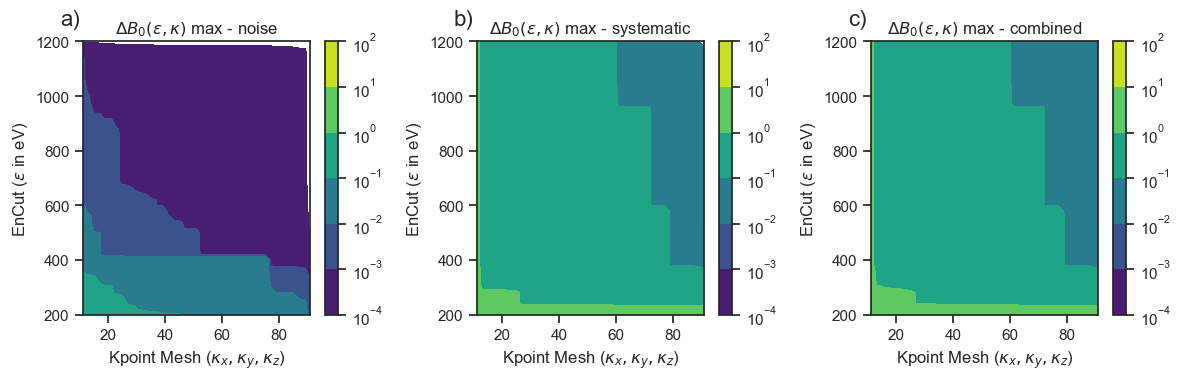

In [46]:
levels = np.geomspace(10 ** -4, 10 ** 2, 7)

f, axs = plt.subplots(1, 3, figsize=(12, 4))

for n, ax in enumerate(axs.flatten()):
    ax.text(-0.1, 1.06, string.ascii_lowercase[n] + ")", transform=ax.transAxes, 
            size=16)

axs[0].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - noise")
mappable = axs[0].contourf(kpoint_mesh, encut_mesh, double_smooth(b0_max_std_mat), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[0])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[0].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[0].set_ylabel("EnCut ($\epsilon$ in eV)")

axs[1].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - systematic")
mappable = axs[1].contourf(kpoint_mesh, encut_mesh, b0_max_diff_mat, vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[1])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[1].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[1].set_ylabel("EnCut ($\epsilon$ in eV)")

axs[2].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - combined")
mappable = axs[2].contourf(kpoint_mesh, encut_mesh, double_smooth(b0_max_diff_mat + b0_max_std_mat), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[2])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[2].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[2].set_ylabel("EnCut ($\epsilon$ in eV)")

f.tight_layout()
plt.show()